In [ ]:
#########################################################
# Author: A. Alsema
# Date: May 2022
# Dataset: Visium Spatial Transcriptomics for MS lesions, slices with WM 
# Purpose: plot gene expression gradient as line plot over the distance
# Output: line graph of distance (x) against gene expression (y)

# Example run for sample A1. The information required to run other samples can be found at the end of the script.

# Required inputs: 
# - outdir: location to store the line graphs
# - seu: seurat object containing all samples with spatial information and subgroup information in the metadata
#########################################################

In [49]:
rm(list = ls())

library(Seurat)
library(stringr)
require(patchwork)
require(ggplot2)
# some custom ggplot lay-out
ggplot.theme <- theme(
                    text = element_text(hjust = 0.5, face = "plain", size = (12)),
                    plot.title = element_text(hjust = 0.5, face = "plain", size = (12)),
                    axis.title.x = element_text(face = "plain", size = (16)),
                    axis.title.y = element_text(face = "plain", size = (16)),
                    axis.text = element_text(face = "plain", size = (16), colour = "black"),
                    plot.subtitle = element_text(hjust = 0.5),
                    panel.background = element_blank(),
                    axis.line = element_line(color = "black"),
                    plot.background = element_rect(fill="transparent", color=NA),
                    legend.key = element_rect(fill="transparent", color="transparent"),
                    legend.box.background = element_rect(fill="transparent", color="transparent"),
                    legend.background = element_rect(fill="transparent", color="transparent"),
                    legend.text=element_text(size=12),
                    legend.title = element_text(size=12),
                    aspect.ratio = 1)
outdir <- "Routput/Seurat/Distance_linegraphs/"

In [56]:
#' Generate Gene Expression Scatter Plots
#'
#' This function generates scatter plots of gene expression data against distance
#' from a lesion center point. It also overlays a loess smooth line if the number
#' of data points exceeds 500.
#'
#' @param seu2 A Seurat object containing spatial data and gene expression. metadata contains the variable subgroup (rim, core, PLWM)
#' @param genes A character vector of gene names to plot.
#' @param ymax A numeric vector specifying the y-axis limits for each gene plot.
#' @param coor A data frame containing tissue coordinates.
#' @param my_alpha A numeric value specifying the transparency of points in the plot.
#' @param region_colors A named vector of colors for different subgroups.
#' @param ggplot.theme A ggplot theme object to customize the plot appearance.
#' @export
#' @examples
#' generate_gene_expression_plots(seu2, c("PLP1", "GPNMB"), c(7, 4), coor, 0.5, region_colors, ggplot.theme)

generate_gene_expression_lineplots <- function(seu2, genes, ymax, coor, my_alpha, region_colors, ggplot.theme) {
  for (i in seq_along(genes)) {
    gene <- genes[i]
    print(paste("plotting", gene))
    counts <- as.data.frame(seu2@assays$Spatial@data[gene,])
    ymax_plot <- ymax[i]
    
    # Add gene expression to the coordinates
    if (gene %in% rownames(seu2)) {
      counts2 <- counts[match(row.names(coor), row.names(counts)), ]
      data <- cbind(coor, counts2)
      data$subgroup <- seu2$subgroup[match(row.names(coor), row.names(seu2@meta.data))]
      data$subgroup <- droplevels(data$subgroup)
    }

    data$subgroup <- factor(data$subgroup, levels = c("active core", "active rim", "active PLWM"))
    # Remove spots with no count detected for the gene of interest or no subgroup assigned
    data_filt <- data[data$counts2 > 0, ]

    # Generate grouped scatter plot with loess line
    p <- ggplot(data_filt, aes(x = distance, y = counts2, color = subgroup)) +
      geom_point(alpha = my_alpha, size = 3) + 
      scale_color_manual(values = region_colors) +
      scale_y_continuous(limits = c(0, ymax_plot), breaks = seq(0, ymax_plot, 1)) +
      theme_classic() +
      xlab("Distance from the (lesion) center point in pixels") +
      ylab("") + # log-normalized expression
      ggtitle(gene) +
      ggplot.theme

    # Add loess line if there are more than 500 data points
    if (nrow(data_filt) > 500) {
      p <- p + geom_smooth(method = "loess", se = TRUE, color = "black", alpha = 0.9)
    }

    print(p)
  }
}


In [51]:
# load data
seu <- readRDS("/data/bcn/Datasets/ST_AAL_JK_WM/RData/seurat/2-1.WM_integrated_scaled_subgroup.rds")
dim(seu)
seu2 <- seu[, !is.na(seu$subgroup)]
dim(seu2)

DefaultAssay(seu2) <- "Spatial"
rm(seu)

[1]  4000 60102

[1]  4000 57021

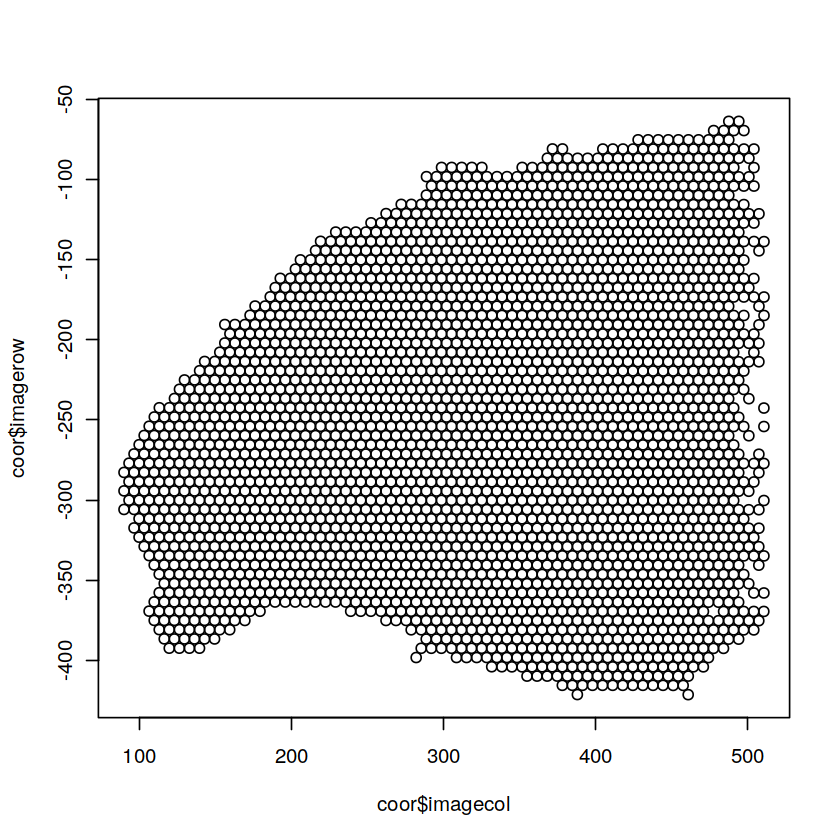

In [54]:
# provide sample information
sample_ID = "ST33" # information to run A1
sample_no = "A1"
current.image = "section3"
center_point = "TAAGGCAACATAAGAT-1_3"
region_colors = c("#E52521", "#1D1D1B", "#A8A8A8")
my_alpha = 0.45

coor <- GetTissueCoordinates(seu2, image = current.image) # "image" selects the sample
coor$imagerow <- coor$imagerow * -1 # plot up side down
plot(coor$imagecol, coor$imagerow) # check shape of the tissue

In [55]:
# add euclidian distance

# define the center point 
origin <- coor[(row.names(coor) == center_point) ,]

# calculate euclidian distance between the point of origin and the moving point X
euclidean <- function(x, new_origin){
    distance = sqrt(sum((x - new_origin)^2))
    return(distance)
    }

# add euclidian distance to coor
coor$distance = apply(coor, 1, euclidean, new_origin = origin)

[1] "plotting PLP1"


`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 18 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 18 rows containing missing values (`geom_point()`).”


[1] "plotting GPNMB"


`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 2 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”


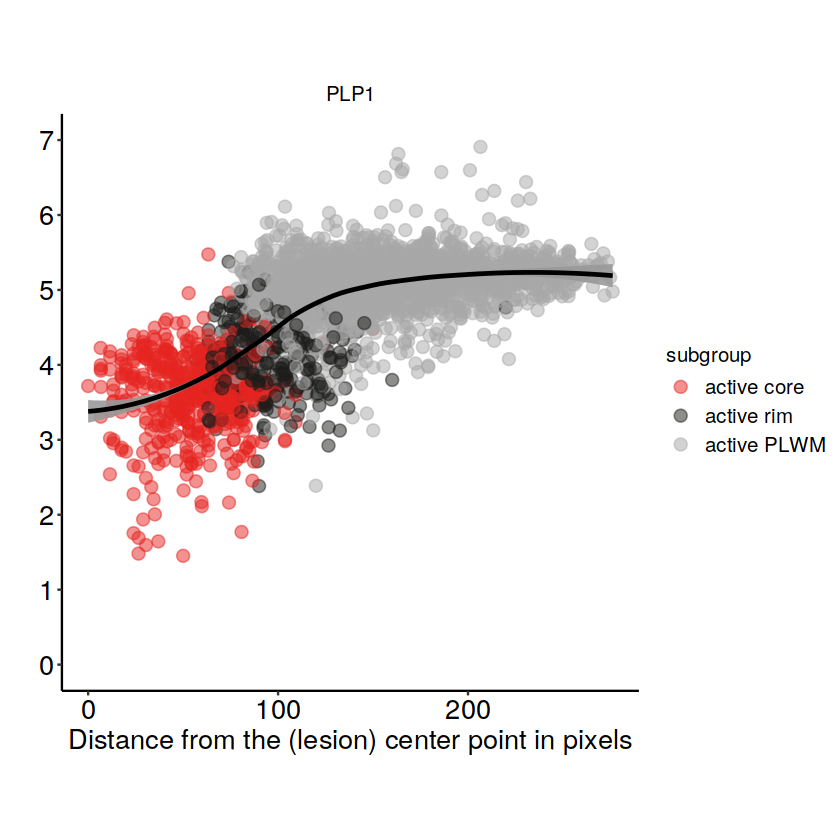

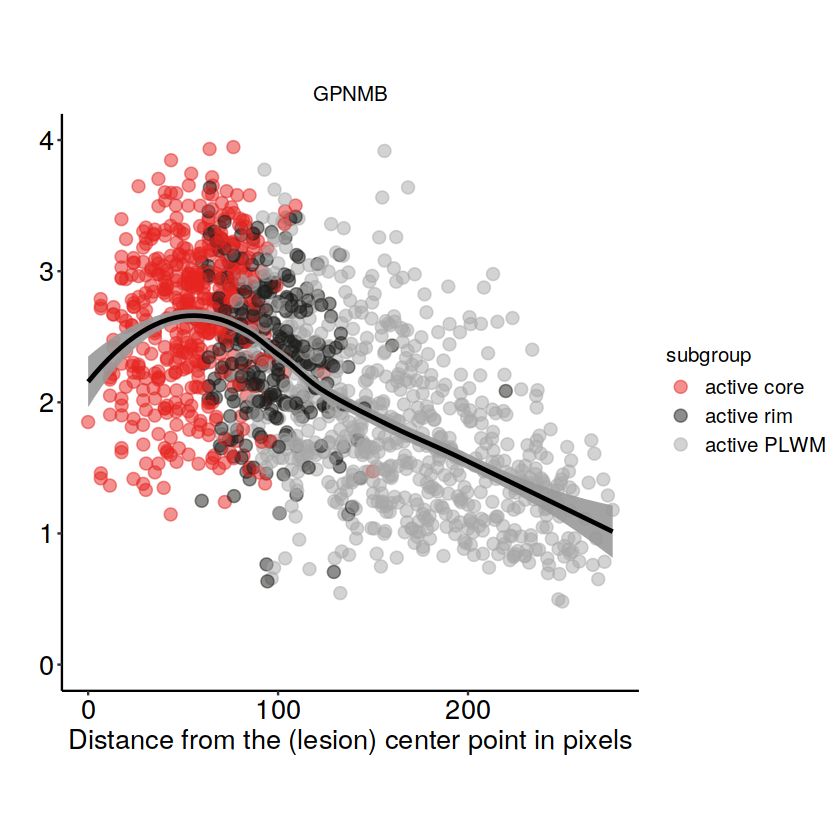

In [57]:

# Example usage (assuming required variables are defined) 
generate_gene_expression_lineplots(seu2, c("PLP1", "GPNMB"), c(7, 4), coor, 0.5, region_colors, ggplot.theme)


In [58]:
# sample_ID = "ST31" # information to run C1
# sample_no = "C1"
# current.image = "section1"
# center_point = "GAATCTGAACATTCTC-1_1"
# region_colors = c("#81C181")
# my_alpha = 1

# sample_ID = "ST32" # information to run C2
# sample_no = "C2"
# current.image = "section2"
# center_point = "ATATTTAACCCTCAAG-1_2"
# region_colors = c("#81C181")
# my_alpha = 1

# sample_ID = "ST34" # information to run N1
# sample_no = "N1"
# current.image = "section4"
# center_point = "TACATTTCTAACGTGC-1_4"
# region_colors = c("#B36F9F")
# my_alpha = 1

# sample_ID = "ST37" # information to run N2
# sample_no = "N2"
# current.image = "section5"
# center_point = "AGCGTGGTATTCTACT-1_5"
# region_colors = c("#B36F9F")
# my_alpha = 1

# sample_ID = "ST38" # information to run N3
# sample_no = "N3"
# current.image = "section6"
# center_point = "ATATCTTAGGGCCTTC-1_6"
# region_colors = c("#B36F9F")
# my_alpha = 1

# sample_ID = "ST33" # information to run A1
# sample_no = "A1"
# current.image = "section3"
# center_point = "TAAGGCAACATAAGAT-1_3"
# region_colors = c("#E52521", "#1D1D1B", "#A8A8A8")
# my_alpha = 0.45

# sample_ID = "ST69" # information to run A2
# sample_no = "A2"
# current.image = "section9"
# center_point = "GTCGTACCATCTCGGG-1_9"
# region_colors = c("#E52521", "#1D1D1B", "#A8A8A8")
# my_alpha = 0.45

# sample_ID = "ST70" # information to run A3
# sample_no = "A3"
# current.image = "section10"
# center_point = "CCGCCGTTGAGGATAA-1_10"
# region_colors = c("#E52521", "#1D1D1B", "#A8A8A8")
# my_alpha = 0.45

# sample_ID = "ST79" # information to run A4
# sample_no = "A4"
# current.image = "section15"
# center_point = "TCTTCGAATAGACGTT-1_15"
# region_colors = c("#E52521", "#1D1D1B", "#A8A8A8")
# my_alpha = 0.45

# sample_ID = "ST67" # information to run M1
# sample_no = "M1"
# current.image = "section7"
# center_point = "CGAGAGATGTGAACCT-1_7"    
# # CHANGE LEVELS
# region_colors = c("#F39326", "#1D1D1B", "#A8A8A8")
# my_alpha = 0.45

# sample_ID = "ST68" # information to run M2
# sample_no = "M2"
# current.image = "section8"
# center_point = "GTGAGTGGTACAACGC-1_8"
# region_colors = c("#F39326", "#1D1D1B", "#A8A8A8")
# my_alpha = 0.45

# sample_ID = "ST71" # information to run M3
# sample_no = "M3"
# current.image = "section11"
# center_point = "GCGGAGAGGGAGAACG-1_11" #ATAAGGTGGAGAACAT-1_11
# region_colors = c("#F39326", "#1D1D1B", "#A8A8A8")
# my_alpha = 0.45

# sample_ID = "ST74" # information to run M4
# sample_no = "M4"
# current.image = "section14"
# center_point = "AGAGTGAACAGACACC-1_14" #TTGCTCCCATACCGGA-1_14
# region_colors = c("#F39326", "#1D1D1B", "#A8A8A8")
# my_alpha = 0.45

# sample_ID = "ST72" # information to run M5
# sample_no = "M5"
# current.image = "section12"
# center_point = "CTCGGGCATCGTCGGG-1_12"  
# region_colors = c("#F39326", "#1D1D1B", "#A8A8A8")
# my_alpha = 0.45

# sample_ID = "ST73" # information to run  M6
# sample_no = "M6"
# current.image = "section13"
# center_point = "TGAAAGGACCTGACTC-1_13"
# region_colors = c("#F39326", "#1D1D1B", "#A8A8A8")
# my_alpha = 0.45

In [59]:
sessionInfo()

R version 4.2.0 (2022-04-22)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.5 LTS

Matrix products: default
BLAS/LAPACK: /data/bcn/p283607/anaconda3/envs/R4.2/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggplot2_3.4.4      patchwork_1.1.3    stringr_1.5.1      SeuratObject_5.0.1
[5] Seurat_4.3.0      

loaded via a namespace (and not attached):
  [1] Rtsne_0.16             colorspace_2.1-0       deldir_2.0-2          
  [4] ellipsis_0.3.2         ggridges_0.5.4         IRdisplay_1.1         
  [7]